<a href="https://colab.research.google.com/github/francescapoli98/pattern-recognition-systems/blob/main/m2_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intelligent Systems for Pattern Recognition: midterm 2**

#### Francesca Poli [560190]

 **Assignment 1:** fit an Hidden Markov Model with Gaussian emissions to the data in the [dataset](https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction). 

- Focus on the *Appliances* and *Lights* columns of the dataset which measure the energy consumption of appliances and lights, respectively, across a period of 4.5 months. Consider the two columns in isolation, i.e. train two separate HMM, one for appliances and one for light.  

- Experiment with HMMs with a varying number of hidden states (e.g. at least 2, 3 and 4). 

- Once trained the HMMs, perform Viterbi on a reasonably sized subsequence (e.g. 1 month of data) and plot the timeseries data highlighting (e.g. with different colours) the hidden state assigned to each timepoint by the Viterbi algorithm.

- Then, fit a single HMM emitting both appliance and light with the same model and repeat the Viterbi assessment. 

- Confront the two results.

## Code

### Getting started

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#installing hmmlearn, a set of algorithms for unsupervised learning and inference of Hidden Markov Models for python

%pip install --upgrade --user hmmlearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#some useful libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from hmmlearn import hmm

#no warnings to distract us (checked before inserting the ignore filter)
import warnings
warnings.filterwarnings("ignore")

#### Loading of the dataset and work setup

**Data Set Information:** the data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).

In [4]:
dataset = pd.read_csv('/content/drive/MyDrive/ISPR/midterm2/energydata_complete.csv')
dataset["date"] = pd.to_datetime(dataset["date"])
dataset = dataset.set_index('date')
dataset

Appliances  lights         T1       RH_1         T2  \
date                                                                       
2016-01-11 17:00:00          60      30  19.890000  47.596667  19.200000   
2016-01-11 17:10:00          60      30  19.890000  46.693333  19.200000   
2016-01-11 17:20:00          50      30  19.890000  46.300000  19.200000   
2016-01-11 17:30:00          50      40  19.890000  46.066667  19.200000   
2016-01-11 17:40:00          60      40  19.890000  46.333333  19.200000   
...                         ...     ...        ...        ...        ...   
2016-05-27 17:20:00         100       0  25.566667  46.560000  25.890000   
2016-05-27 17:30:00          90       0  25.500000  46.500000  25.754000   
2016-05-27 17:40:00         270      10  25.500000  46.596667  25.628571   
2016-05-27 17:50:00         420      10  25.500000  46.990000  25.414000   
2016-05-27 18:00:00         430      10  25.500000  46.600000  25.264286   

                          RH_2         T3       RH_3         T4       RH_4  \
date                                                                         
2016-01-11 17:00:00  44.790000  19.790000  44.730000  19.000000  45.566667   
2016-01-11 17:10:00  44.722500  19.790000  44.790000  19.000000  45.992500   
2016-01-11 17:20:00  44.626667  19.790000  44.933333  18.926667  45.890000   
2016-01-11 17:30:00  44.590000  19.790000  45.000000  18.890000  45.723333   
2016-01-11 17:40:00  44.530000  19.790000  45.000000  18.890000  45.530000   
...                        ...        ...        ...        ...        ...   
2016-05-27 17:20:00  42.025714  27.200000  41.163333  24.700000  45.590000   
2016-05-27 17:30:00  42.080000  27.133333  41.223333  24.700000  45.590000   
2016-05-27 17:40:00  42.768571  27.050000  41.690000  24.700000  45.730000   
2016-05-27 17:50:00  43.036000  26.890000  41.290000  24.700000  45.790000   
2016-05-27 18:00:00  42.971429  26.823333  41.156667  24.700000  45.963333   

                     ...         T9     RH_9      T_out  Press_mm_hg  \
date                 ...                                               
2016-01-11 17:00:00  ...  17.033333  45.5300   6.600000        733.5   
2016-01-11 17:10:00  ...  17.066667  45.5600   6.483333        733.6   
2016-01-11 17:20:00  ...  17.000000  45.5000   6.366667        733.7   
2016-01-11 17:30:00  ...  17.000000  45.4000   6.250000        733.8   
2016-01-11 17:40:00  ...  17.000000  45.4000   6.133333        733.9   
...                  ...        ...      ...        ...          ...   
2016-05-27 17:20:00  ...  23.200000  46.7900  22.733333        755.2   
2016-05-27 17:30:00  ...  23.200000  46.7900  22.600000        755.2   
2016-05-27 17:40:00  ...  23.200000  46.7900  22.466667        755.2   
2016-05-27 17:50:00  ...  23.200000  46.8175  22.333333        755.2   
2016-05-27 18:00:00  ...  23.200000  46.8450  22.200000        755.2   

                        RH_out  Windspeed  Visibility  Tdewpoint        rv1  \
date                                                                          
2016-01-11 17:00:00  92.000000   7.000000   63.000000   5.300000  13.275433   
2016-01-11 17:10:00  92.000000   6.666667   59.166667   5.200000  18.606195   
2016-01-11 17:20:00  92.000000   6.333333   55.333333   5.100000  28.642668   
2016-01-11 17:30:00  92.000000   6.000000   51.500000   5.000000  45.410389   
2016-01-11 17:40:00  92.000000   5.666667   47.666667   4.900000  10.084097   
...                        ...        ...         ...        ...        ...   
2016-05-27 17:20:00  55.666667   3.333333   23.666667  13.333333  43.096812   
2016-05-27 17:30:00  56.000000   3.500000   24.500000  13.300000  49.282940   
2016-05-27 17:40:00  56.333333   3.666667   25.333333  13.266667  29.199117   
2016-05-27 17:50:00  56.666667   3.833333   26.166667  13.233333   6.322784   
2016-05-27 18:00:00  57.000000   4.000000   27.000000  13.200000  34.118851   

                           rv2  
date               

### Time Series
To begin, the whole dataset is subdivided into three dataframes: one contianing only the `Appliances` column, one containing the `Lights` column only and lastly one containing both of them for the last task of comparison.

In [5]:
both_df = dataset[['Appliances', 'lights']].copy()
both_df.columns=['appliances', 'lights']

#Appliances: energy use in Wh
appl_df = dataset[['Appliances']].copy()
appl_df.columns = ['appliances']

#lights: energy use of light fixtures in the house in Wh
lights_df = dataset[['lights']].copy()

display(both_df[:5], appl_df[:5], lights_df[:5])

appliances  lights
date                                   
2016-01-11 17:00:00          60      30
2016-01-11 17:10:00          60      30
2016-01-11 17:20:00          50      30
2016-01-11 17:30:00          50      40
2016-01-11 17:40:00          60      40

appliances
date                           
2016-01-11 17:00:00          60
2016-01-11 17:10:00          60
2016-01-11 17:20:00          50
2016-01-11 17:30:00          50
2016-01-11 17:40:00          60

lights
date                       
2016-01-11 17:00:00      30
2016-01-11 17:10:00      30
2016-01-11 17:20:00      30
2016-01-11 17:30:00      40
2016-01-11 17:40:00      40

In [6]:
both_df.info()
appl_df.info()
lights_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   appliances  19735 non-null  int64
 1   lights      19735 non-null  int64
dtypes: int64(2)
memory usage: 462.5 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   appliances  19735 non-null  int64
dtypes: int64(1)
memory usage: 308.4 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   lights  19735 non-null  int64
dtypes: int64(1)
memory usage: 308.4 KB


Let's plot the time series in order to look at the distribution of our data. 

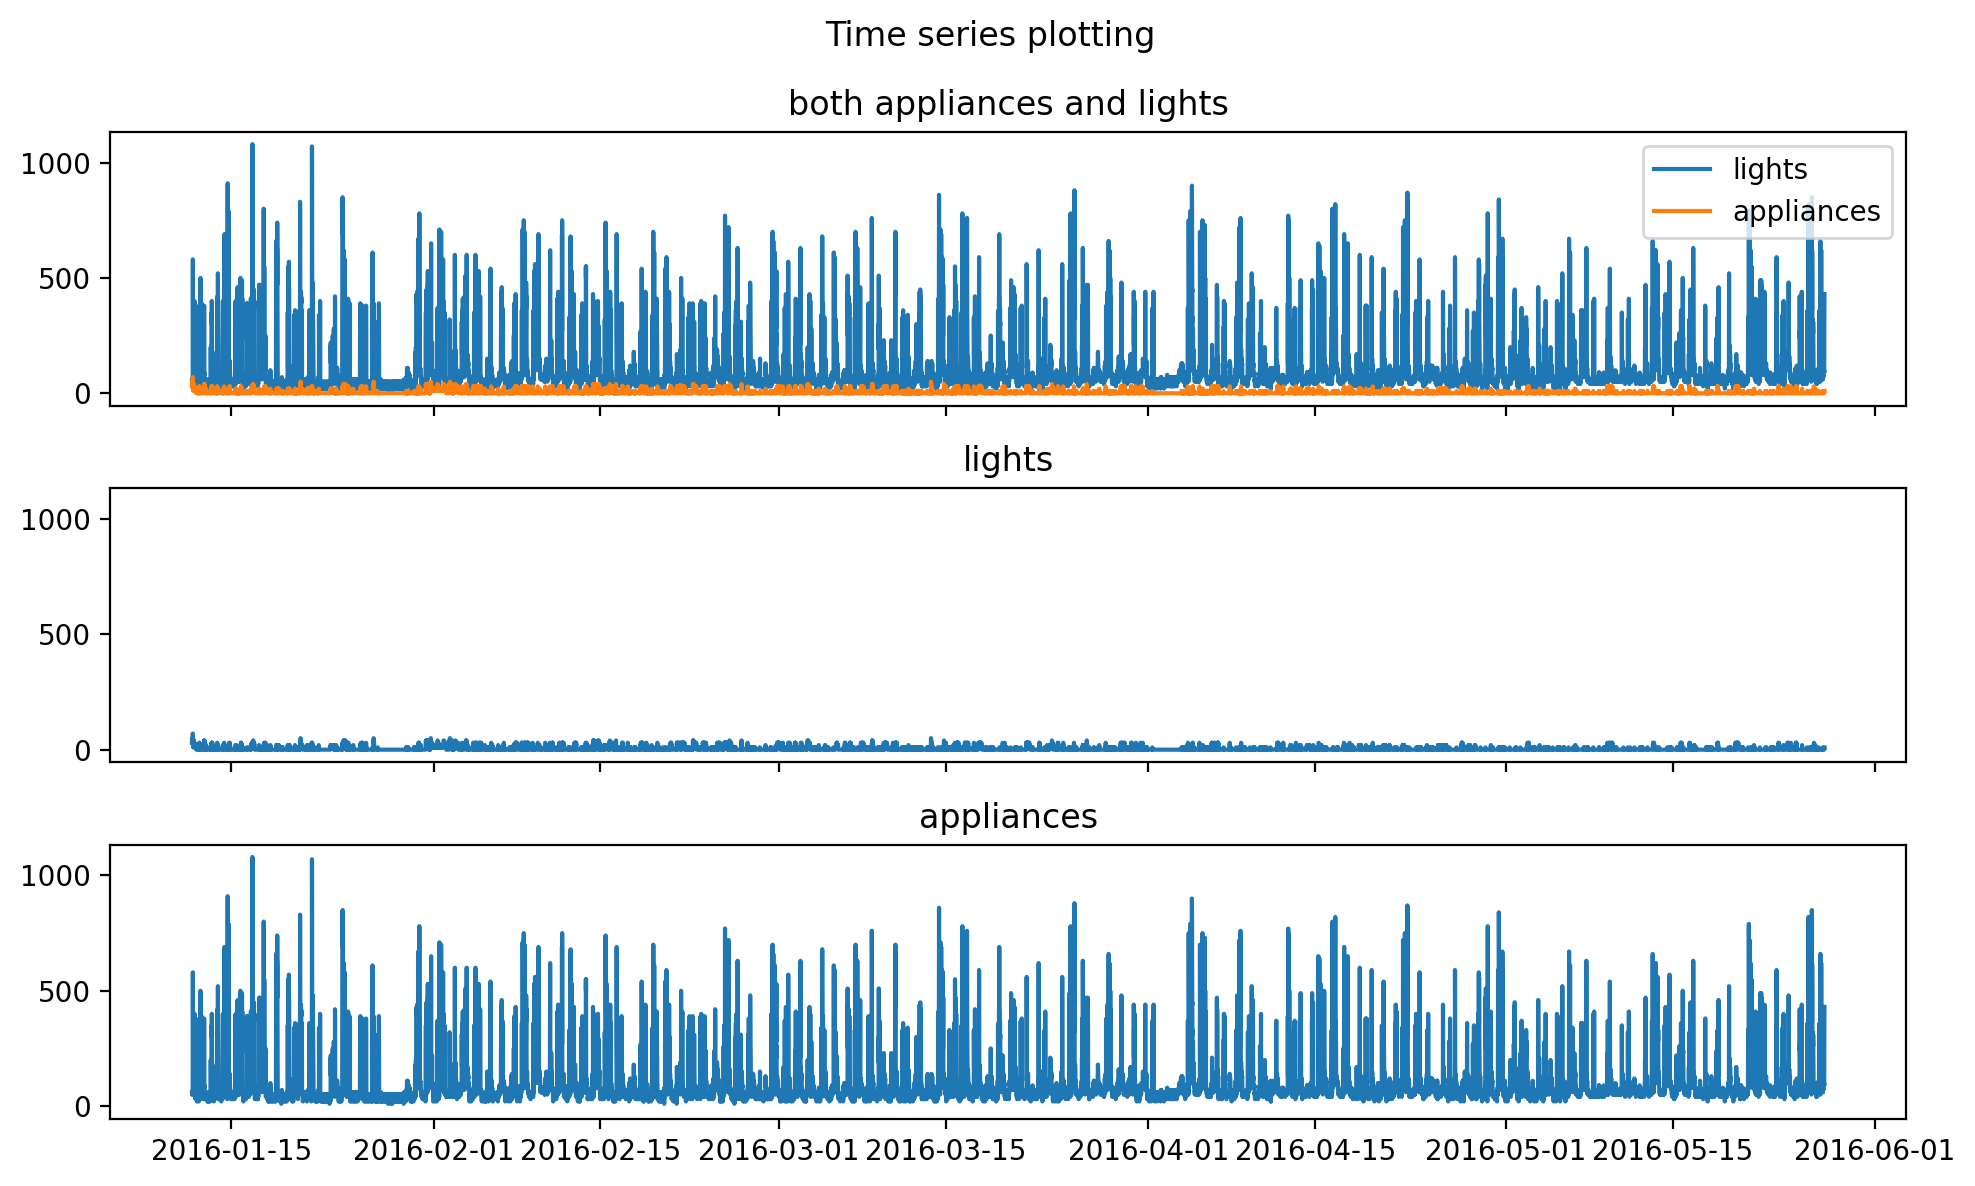

In [7]:
fig, axs = plt.subplots(3,1, figsize=(10,6), dpi=200, sharey=True, sharex=True)
fig.suptitle('Time series plotting')

axs[0].plot(both_df)
axs[0].legend(['lights', 'appliances'])
axs[0].set_title("both appliances and lights")

axs[1].plot(lights_df)
axs[1].set_title("lights")

axs[2].plot(appl_df)
axs[2].set_title("appliances")

fig.tight_layout() 

### Fitting Hidden Markov Models with Gaussian emissions 
Let's start by fitting the dataframes containing `appliances` and `lights` data into a Hidden Markov Model without the Viterbi algorithm and let's see how the default algorithm of `GaussianHMM` by `sklearn` handles the data.
As for the number of hidden states, it might be interesting to run a more extensive research, so we choose the recommended 2, 3 and 4, and add others up to 10 hidden states, in order to see how the Hidden Markov Model handles some more complexity.

In [8]:
hiddens=[2,3,4,6,8,10] #hidden states 

In [9]:
from hmmlearn.hmm import GaussianHMM 

def hmm_builder(hiddens, X):
  # Build the HMM model and fit to the different datasets.
  model = hmm.GaussianHMM(n_components = hiddens, covariance_type = "diag", n_iter = 50, random_state = 42)
  model.fit(X) #data
  # Predict the hidden states corresponding to observed X.
  Z = model.predict(X)
  states = pd.unique(Z)

  transmat = model.transmat_
  means = model.means_


  return hiddens, Z, states, transmat, means

####################################
#returns an array of results:
#   hiddens: number of hidden states 
#   Z: prediction of the hidden states 
#   states: hidden states' labels
#   transmat: transition matrix
#   means: mean parameters for each state
####################################


In [10]:
for i in hiddens:
  print('\n \t Testing Gaussian Hidden Markov Model with {} hidden units: \n'.format(i))
  
  lights = hmm_builder(i, lights_df)
  print('GHMM fitted in LIGHTS dataframe: \n First 50 values in Z = {} \n States = {} \n\n Transition matrix = {} \n Mean parameters for each state = {}'.format(lights[1][:50], 
                                                                                                                                                                                              lights[2],
                                                                                                                                                                                              lights[3],
                                                                                                                                                                                              lights[4],
                                                                                                                                                                                              ))
  
  appl = hmm_builder(i, appl_df)
  print('GHMM fitted in APPLIANCES dataframe: \n First 50 values in Z = {} \n States = {} \n\n Transition matrix = {} \n Mean parameters for each state = {}'.format(appl[1][:50], 
                                                                                                                                                                                              appl[2],
                                                                                                                                                                                              appl[3],
                                                                                                                                                                                              appl[4],
                                                                                                                                                                                              ))
                    
  


 	 Testing Gaussian Hidden Markov Model with 2 hidden units: 

GHMM fitted in LIGHTS dataframe: 
 First 50 values in Z = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1] 
 States = [1 0] 

 Transition matrix = [[0.91955602 0.08044398]
 [0.27373867 0.72626133]] 
 Mean parameters for each state = [[ 0.        ]
 [16.73619351]]
GHMM fitted in APPLIANCES dataframe: 
 First 50 values in Z = [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 1 1 1 1] 
 States = [0 1] 

 Transition matrix = [[0.97303335 0.02696665]
 [0.05925196 0.94074804]] 
 Mean parameters for each state = [[ 54.89115371]
 [191.9871541 ]]

 	 Testing Gaussian Hidden Markov Model with 3 hidden units: 

GHMM fitted in LIGHTS dataframe: 
 First 50 values in Z = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 1 0 0 0 1 0 0 0] 
 States = [0 1 2] 

 Transition matrix = [[0.79396502 0.15936105 0.0

### Fitting Viterbi algorithm to light and appliances separately
Here we decided to take into consideration 2 months of data (from *January 11th*, the starting date, to *March 11th*), for a total of **61 days** to be analyzed using the **Viterbi algorithm**.
Those dates were chosen as representative and worth of a deeper analysis because of the sudden and short depression in the pattern and the repetition of the same pattern in the following months. Thus, a sequence is identified.

In [11]:
appl_seq = appl_df['2016-01' : '2016-03-11']
lights_seq = lights_df['2016-01' : '2016-03-11']
both_seq = both_df['2016-01' : '2016-03-11']

In [12]:
#Perform Viterbi on GaussianHMM

def hmm_viterbi(hiddens, X):
  # Build the HMM model with Viterbi algorithm and fit.
  model = hmm.GaussianHMM(algorithm='viterbi', n_components = hiddens, covariance_type = "diag", n_iter = 50, random_state = 42)
  model.fit(X) 
  # Predict the hidden states corresponding to observed X.
  Z = model.predict(X)
  states = pd.unique(Z)
  
  #features = model.n_features
  #startprob = model.startprob_
  likelihood = model.score(X)
  transmat = model.transmat_
  means = model.means_


  return Z, states, likelihood, transmat, means


####################################
# returns an array of results:
#   Z: prediction of the hidden states 
#   states: hidden states' labels
#   likelihood: log-likelihood 
#   transmat: transition matrix
#   means: mean parameters for each state
####################################


In [13]:
v_lights={}
v_appl={}

for i in hiddens:
  print('\n \t Testing Gaussian Hidden Markov Model (Viterbi) with {} hidden units: \n'.format(i))
  
  v_lights[i] = hmm_viterbi(i, lights_seq)
  print('GHMM fitted in LIGHTS dataframe: \n First 30 values in Z = {} \n States = {} \n\n Likelihood = {} \n Transition matrix = {} \n Mean parameters for each state = {}'.format(v_lights[i][0][:30], 
                                                                                                                                                                                              v_lights[i][1],
                                                                                                                                                                                              v_lights[i][2],
                                                                                                                                                                                              v_lights[i][3],
                                                                                                                                                                                              v_lights[i][4]))
  v_appl[i] = hmm_viterbi(i, appl_seq)
  print('\n GHMM fitted in APPLIANCES dataframe: \n First 30 values in Z = {} \n States = {}  \n\n Likelihood = {} \n Transition matrix = {} \n Mean parameters for each state = {}'.format(v_appl[i][0][:30], 
                                                                                                                                                                                              v_appl[i][1],
                                                                                                                                                                                              v_appl[i][2],
                                                                                                                                                                                              v_appl[i][3],
                                                                                                                                                                                              v_appl[i][4]))


 	 Testing Gaussian Hidden Markov Model (Viterbi) with 2 hidden units: 

GHMM fitted in LIGHTS dataframe: 
 First 30 values in Z = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 
 States = [1 0] 

 Likelihood = 21073.92155833288 
 Transition matrix = [[0.90392017 0.09607983]
 [0.20878769 0.79121231]] 
 Mean parameters for each state = [[ 0.        ]
 [17.43990257]]

 GHMM fitted in APPLIANCES dataframe: 
 First 30 values in Z = [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 
 States = [0 1]  

 Likelihood = -43486.56198409604 
 Transition matrix = [[0.96875733 0.03124267]
 [0.06568388 0.93431612]] 
 Mean parameters for each state = [[ 50.19840463]
 [197.45872182]]

 	 Testing Gaussian Hidden Markov Model (Viterbi) with 3 hidden units: 

GHMM fitted in LIGHTS dataframe: 
 First 30 values in Z = [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0] 
 States = [0 1 2] 

 Likelihood = 31410.78636129573 
 Transition matrix = [[0.81742375 0.14222246 0.0

#### Hidden states timepoints
The next step is plotting the timeseries data highlighting the hidden state assigned to each timepoint by the Viterbi algorithm. This is achieved through a function, plot_timepoints, which creates a scatterplot for each number of hidden states of the two dataframes, exploiting the resulting states of the prediction using the Hidden Markov Model.

In [14]:
def plot_timepoints(hiddens, states, seq, name):
  fig = plt.figure(figsize=(30, 10), dpi=200)
  fig.suptitle('Time points in Hidden Markov Models in {} dataset'.format(name)) 
  k = 0
  for s in hiddens:
    k=k+1
    ax = fig.add_subplot(3,2,k)
    ax.title.set_text('{} hidden states'.format(s)) 
    y = states[s][0]
    x = seq.index

    colors=[]
    for i in y:
      if i == 0:
          colors.append('r')  
      elif i == 1:
          colors.append('g') 
      elif i == 2:
          colors.append('b') 
      elif i == 3:
          colors.append('y') 
      elif i == 4:
          colors.append('m') 
      elif i == 5:
          colors.append('c') 
      elif i == 6:
          colors.append('k') 
      elif i == 7:
          colors.append('pink') 
      elif i == 8:
          colors.append('gray') 
      elif i == 9:
          colors.append('orange') 
      else:
        colors.append('magenta') 
          
      # plotting the corresponding x with y and respective color
    plt.scatter(x, seq[name], c = colors, s = 1)
  plt.tight_layout()
  plt.show()


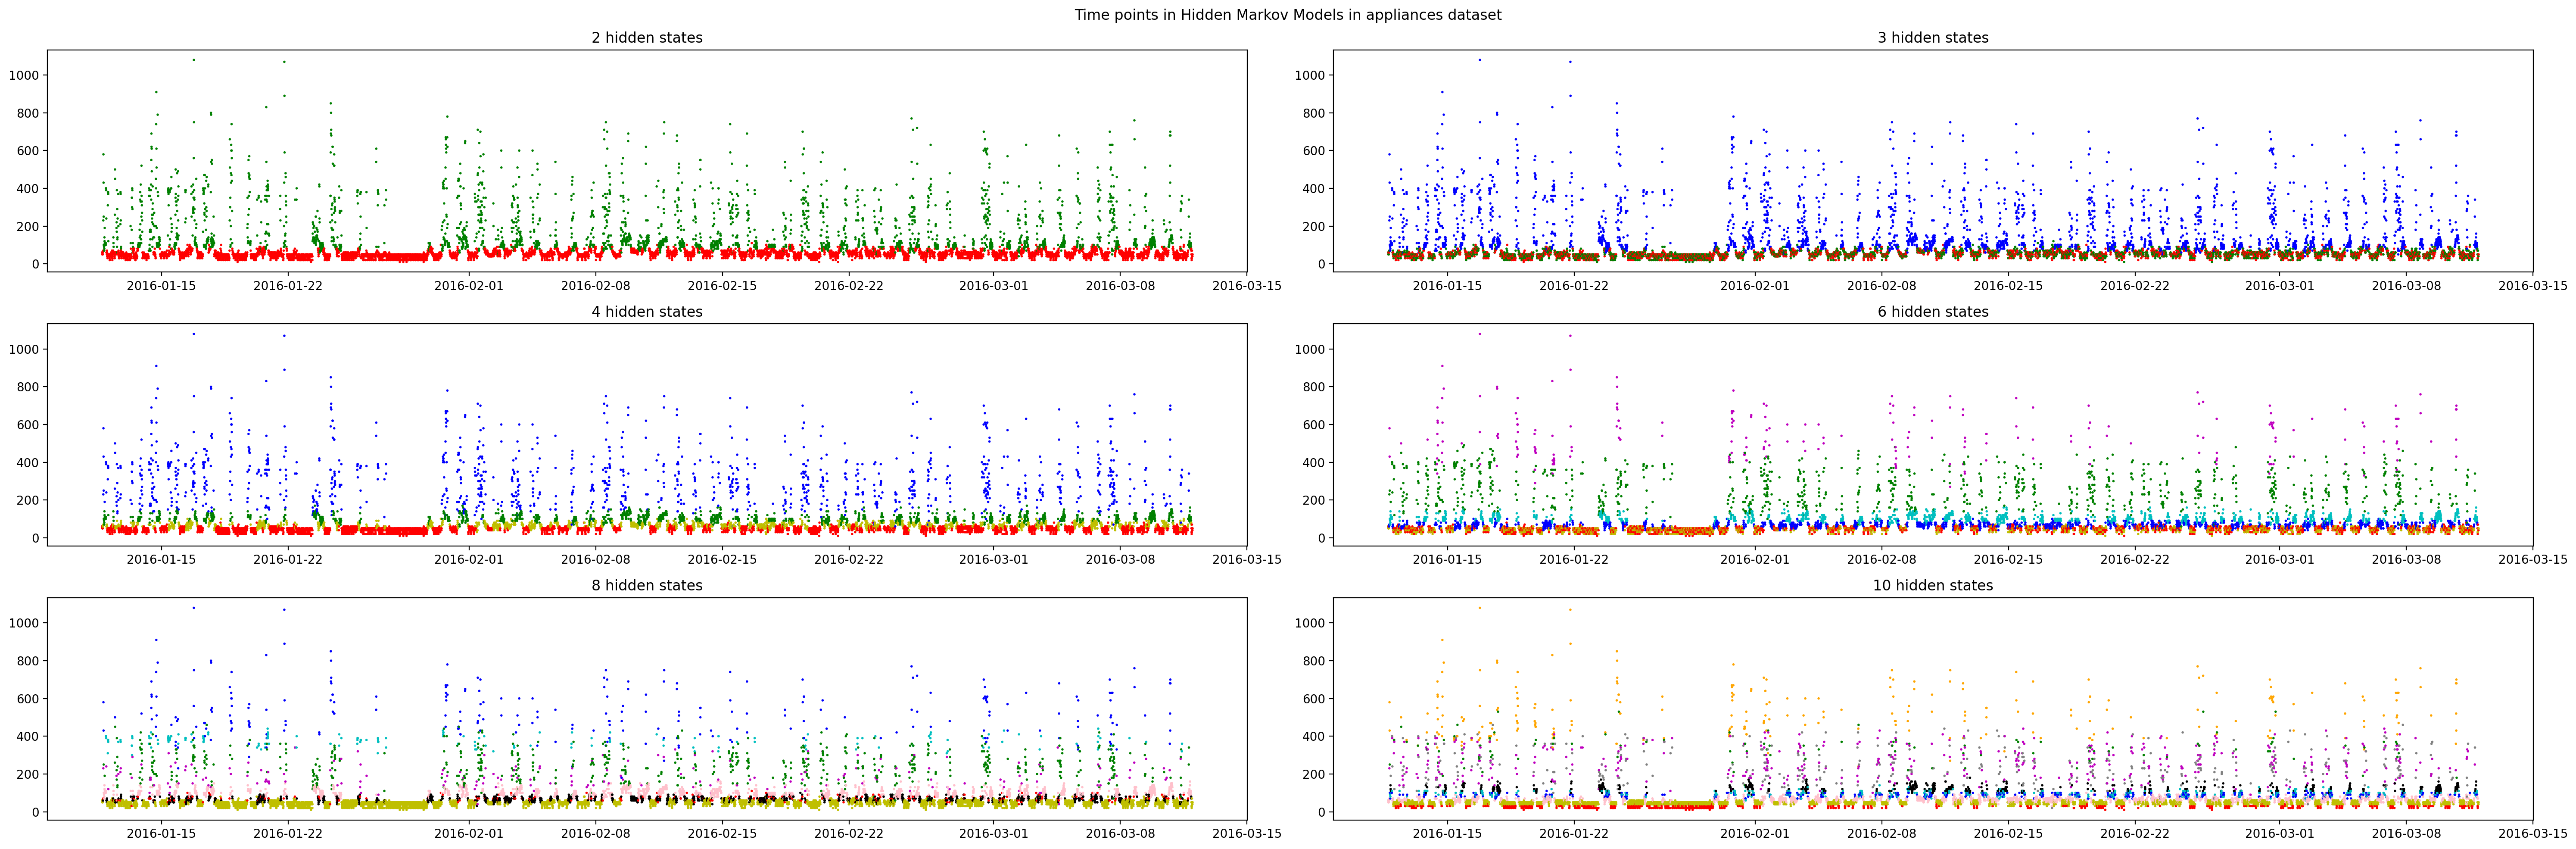

In [15]:
plot_timepoints(hiddens, v_appl, appl_seq, 'appliances')

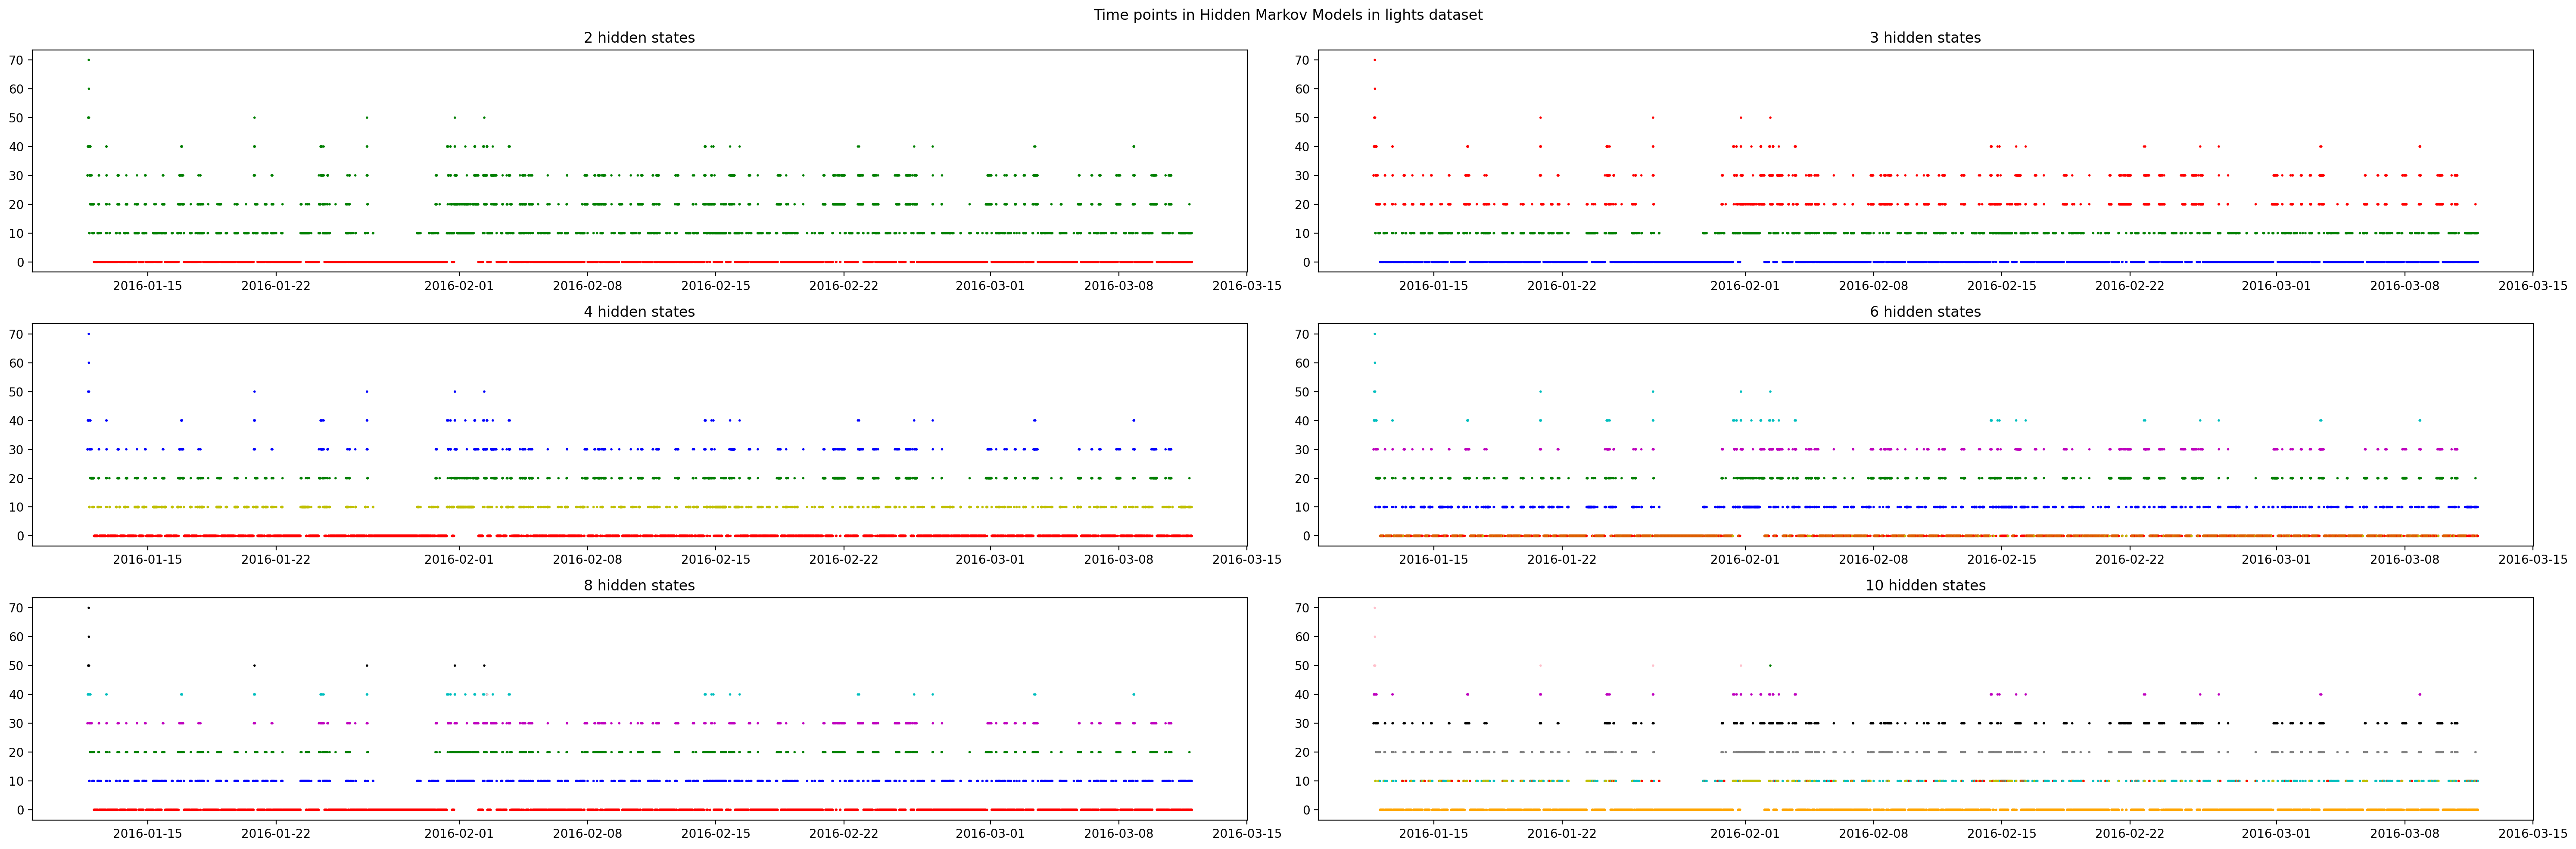

In [16]:
plot_timepoints(hiddens, v_lights, lights_seq, 'lights')

It seems that the more are the hidden states, the sparser the mean parameters get, also generating some recurring values.
In the `lights` dataset, the mean parameters are never higher than 54, while in the `appliances` dataset they reach values more than twice as much.

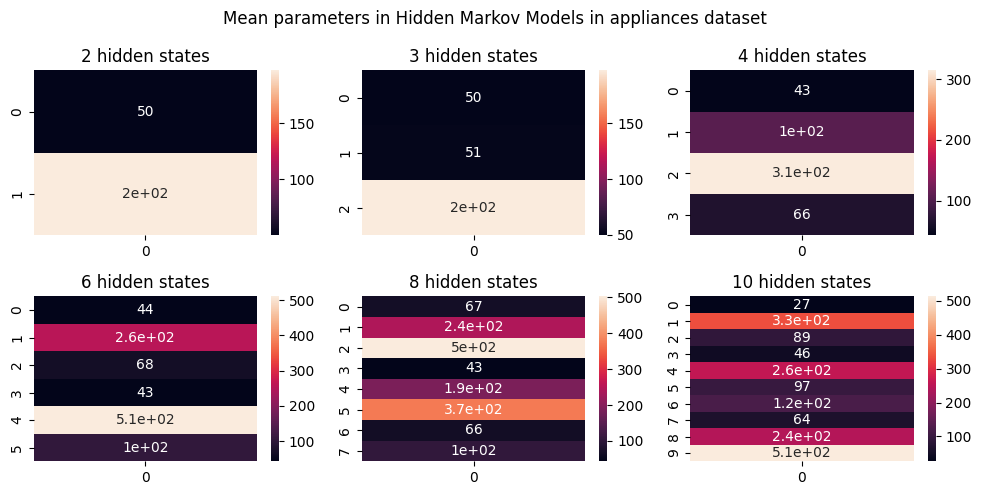

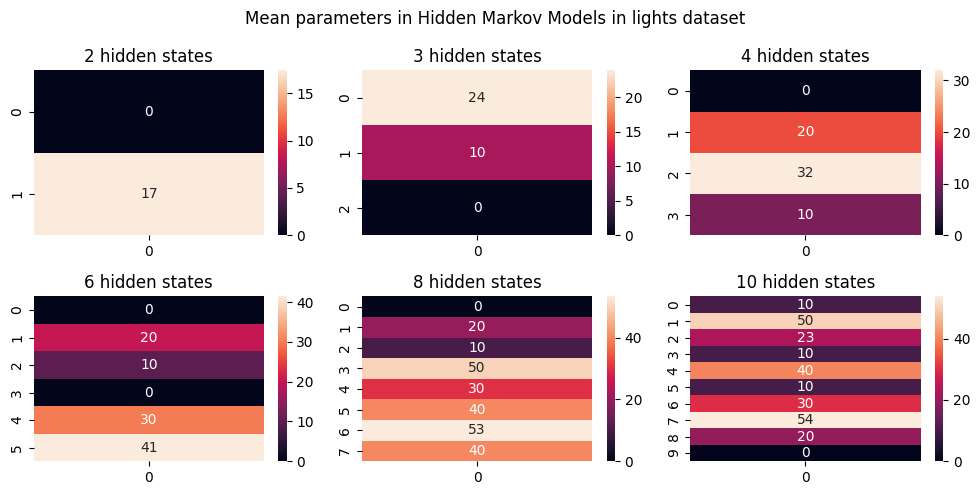

In [17]:
def meanparams(params, name):

  fig = plt.figure(figsize=(10, 5), dpi=100)
  fig.suptitle('Mean parameters in Hidden Markov Models in {} dataset'.format(name)) 
  k = 0
  for i in hiddens:
    k=k+1
    ax = fig.add_subplot(2,3,k)
    ax.title.set_text('{} hidden states'.format(i)) 
    ax = sns.heatmap(params[i][4], annot=True) 
  plt.tight_layout()
  plt.show()

meanparams(v_appl, 'appliances')
meanparams(v_lights, 'lights')

At this point a new very simple function, `means()`, just plots the the development of mean parameters for each hidden state, assigning a different color for each step (*h.s. in legend*).

In [18]:
def means(seq, name):
  for i in hiddens:
    plt.title('{} data'.format(name)) 
    plt.plot(seq[i][4], label='{} h.s.'.format(i)) #sns heatmaps
  plt.legend()
  plt.plot()

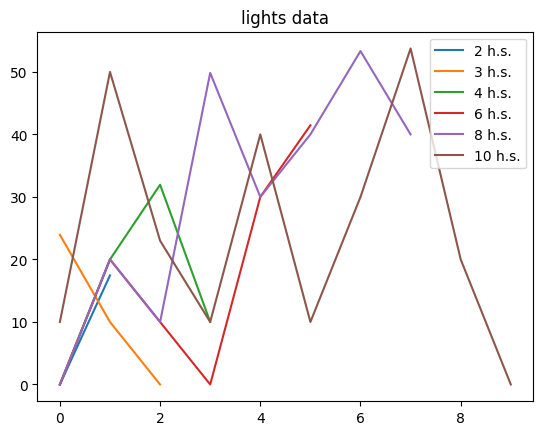

In [19]:
means(v_lights, 'lights') 

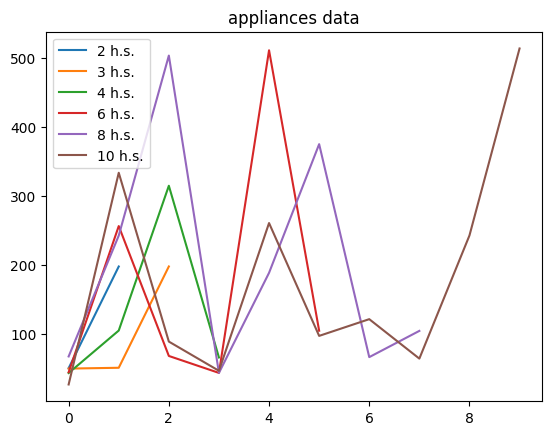

In [20]:
means(v_appl, 'appliances')

### Appliances and lights both fitting in a single Hidden Markov Model with Viterbi algorithm

In [21]:
v_both={}

for i in hiddens:
  print('\n \t Testing Gaussian Hidden Markov Model (Viterbi) with {} hidden units: \n'.format(i))
  
  v_both[i] = hmm_viterbi(i, both_seq)
  print('\n First 30 values in Z = {} \n States = {}  \n\n Likelihood = {} \n Transition matrix = {} \n Mean parameters for each state = {}'.format(v_both[i][0][:30], 
                                                                                                                                                                                              v_both[i][1],
                                                                                                                                                                                              v_both[i][2],
                                                                                                                                                                                              v_both[i][3],
                                                                                                                                                                                              v_both[i][4]))


 	 Testing Gaussian Hidden Markov Model (Viterbi) with 2 hidden units: 


 First 30 values in Z = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1] 
 States = [1 0]  

 Likelihood = -30121.65499141613 
 Transition matrix = [[0.89073072 0.10926928]
 [0.18763245 0.81236755]] 
 Mean parameters for each state = [[ 55.91700562   0.        ]
 [169.23157018  14.93628294]]

 	 Testing Gaussian Hidden Markov Model (Viterbi) with 3 hidden units: 


 First 30 values in Z = [2 2 2 2 2 2 2 2 2 2 0 0 0 0 2 2 2 2 2 2 2 0 2 2 2 2 2 2 2 2] 
 States = [2 0 1]  

 Likelihood = -27483.527467936095 
 Transition matrix = [[0.78256296 0.11360614 0.1038309 ]
 [0.02443554 0.89085025 0.0847142 ]
 [0.0615251  0.23139396 0.70708093]] 
 Mean parameters for each state = [[323.3332105   11.34471081]
 [ 55.98527526   0.        ]
 [ 78.34522877  17.07609389]]

 	 Testing Gaussian Hidden Markov Model (Viterbi) with 4 hidden units: 


 First 30 values in Z = [2 2 2 3 3 3 3 3 3 3 3 3 3 3 2 2 2 2 2 3 3 3 3 3 

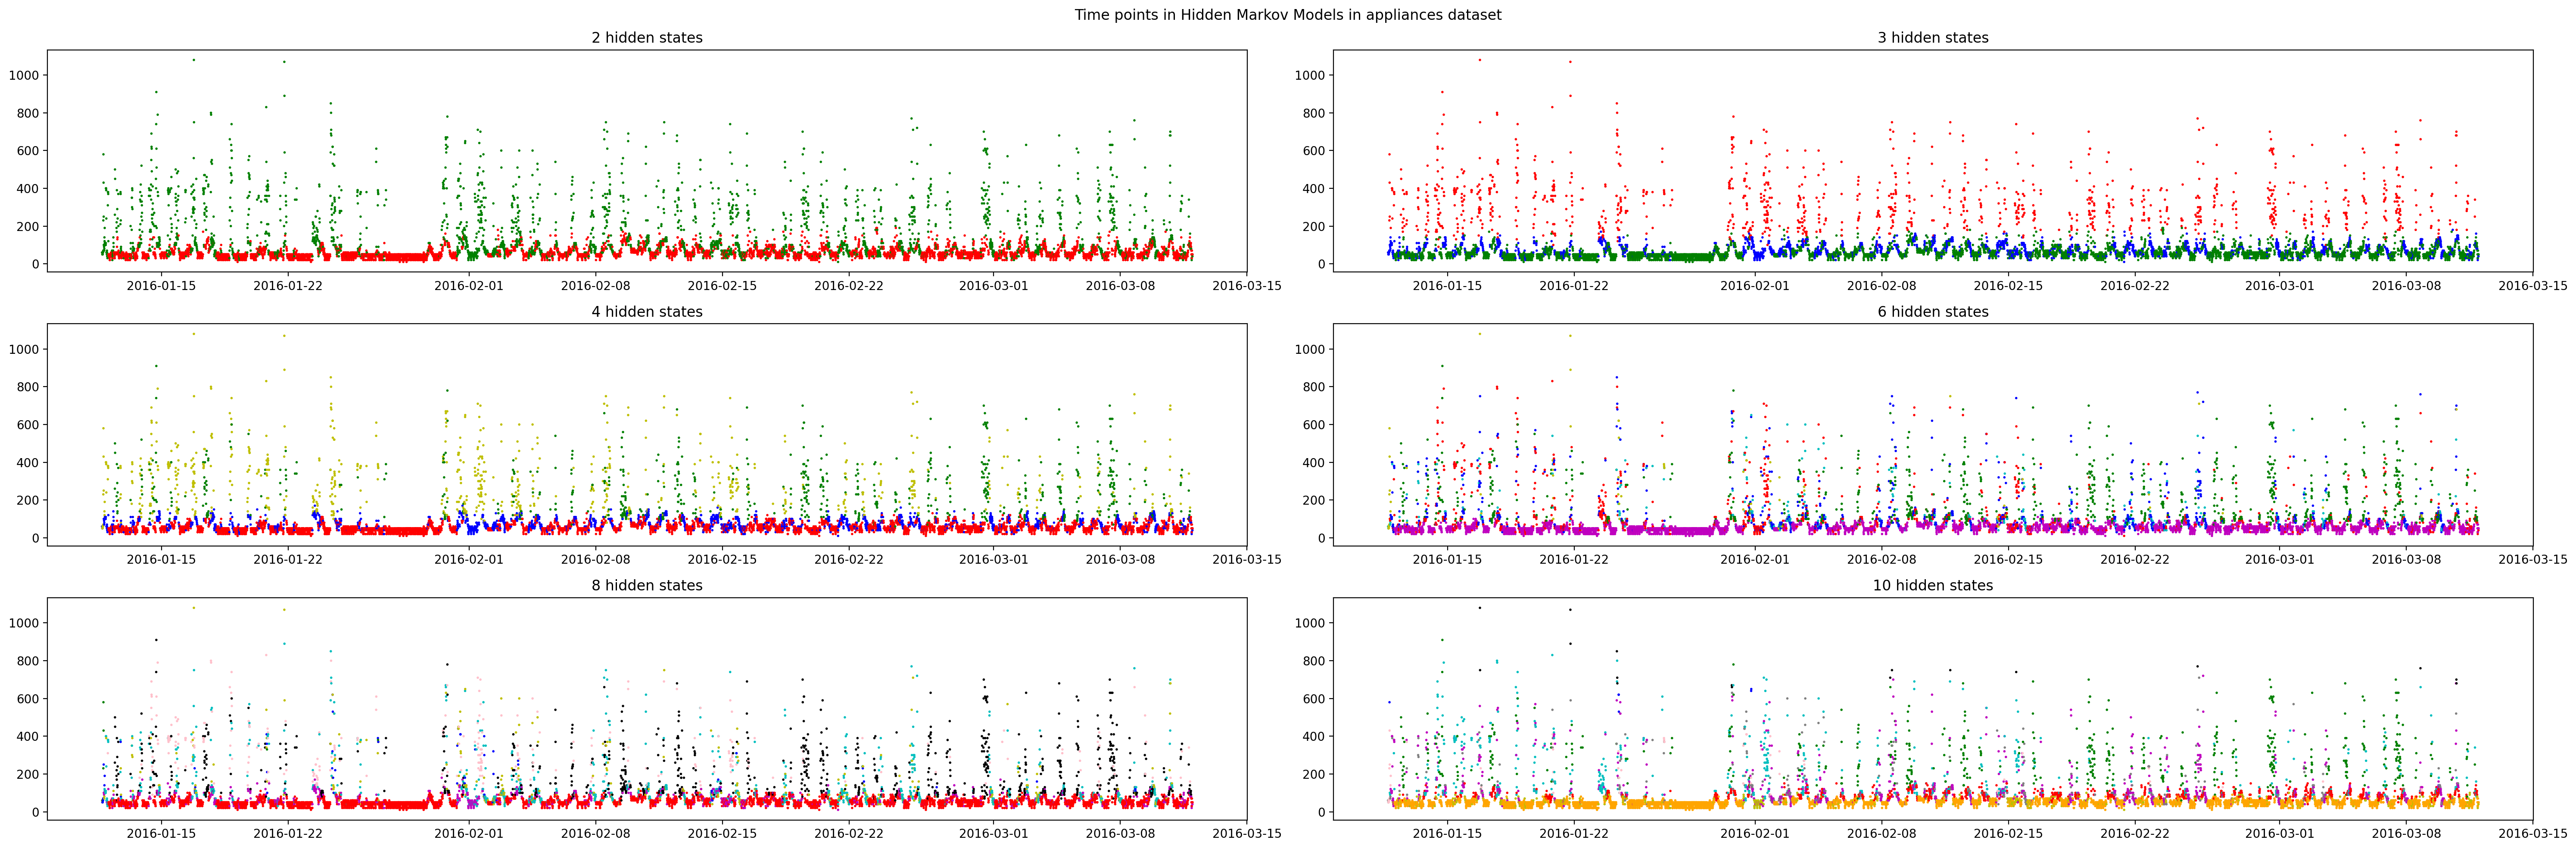

In [22]:
plot_timepoints(hiddens, v_both, both_seq, 'appliances')

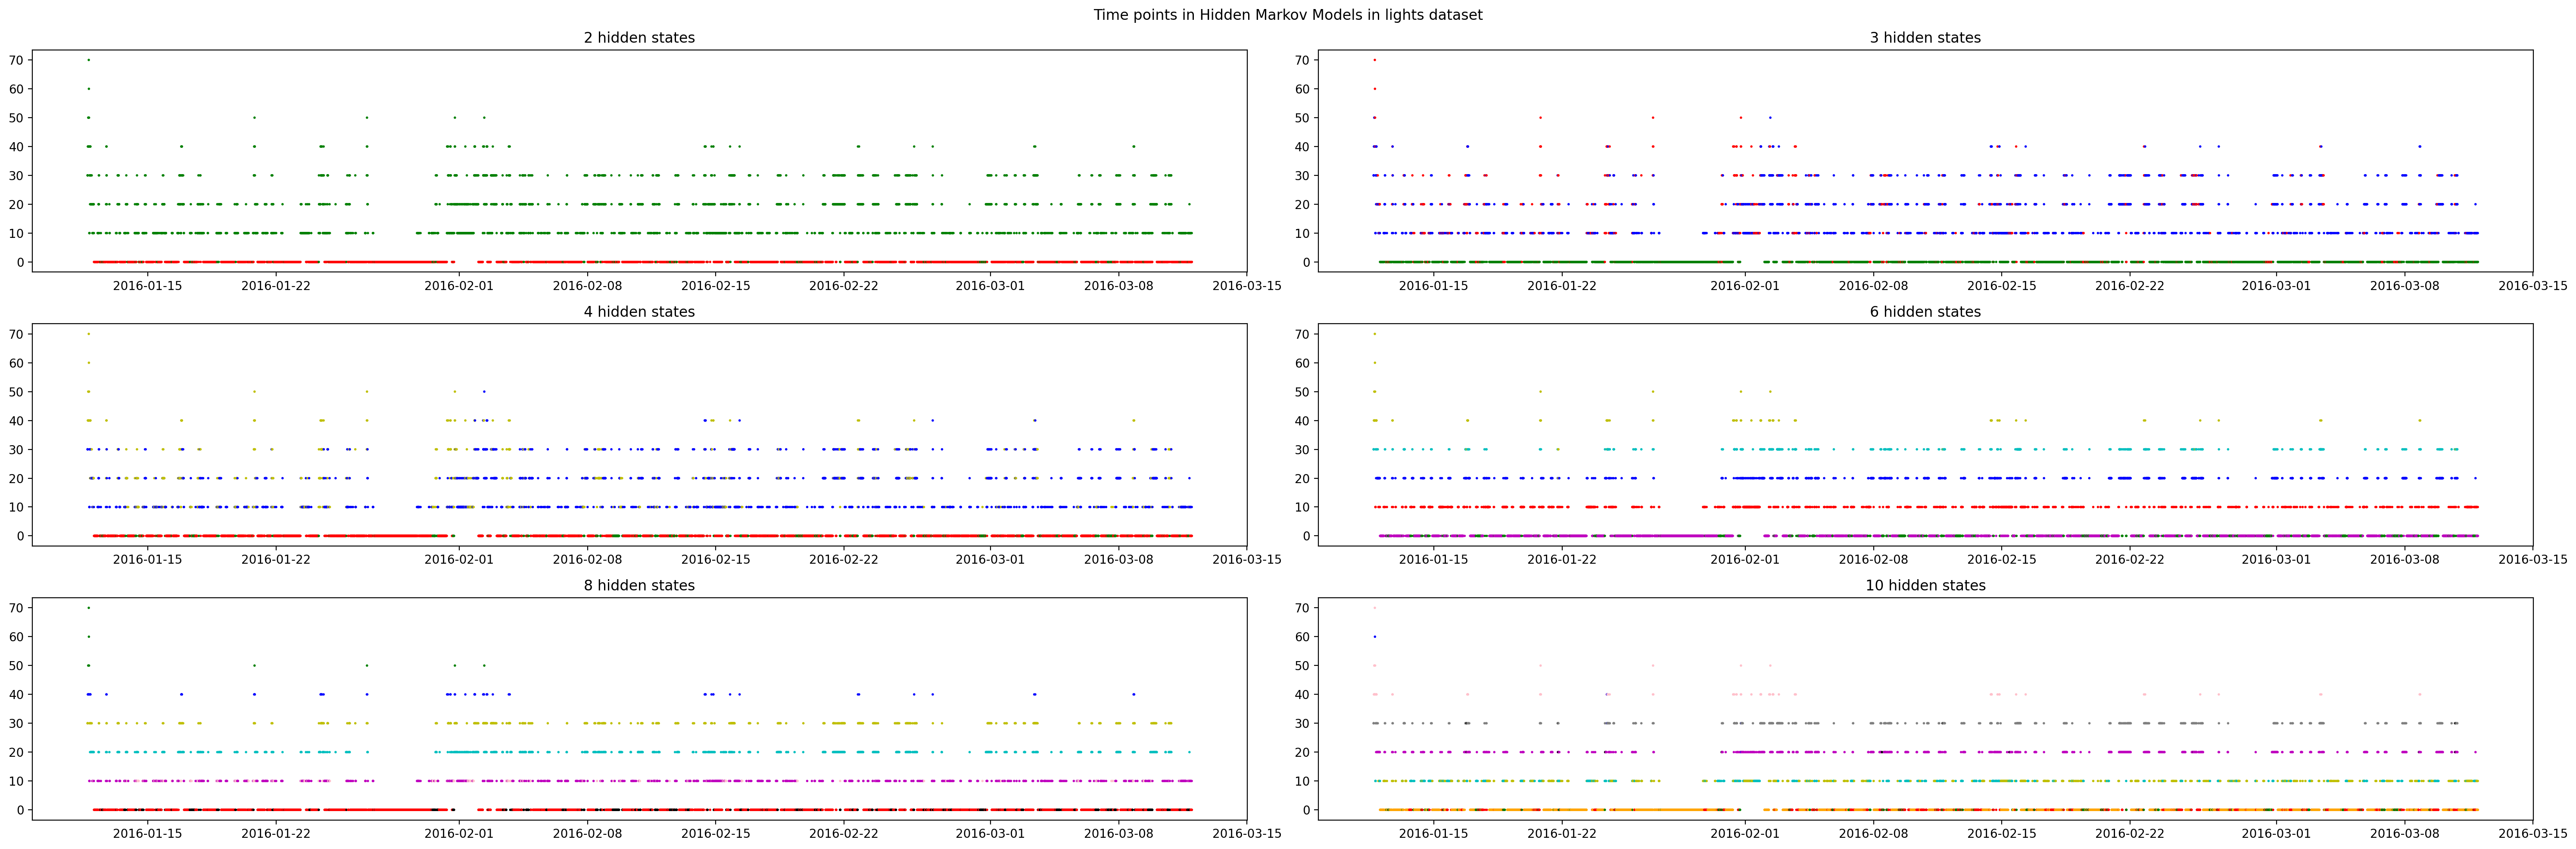

In [23]:
plot_timepoints(hiddens, v_both, both_seq, 'lights')

Now let's plot the mean parameters found in this dataset: to understand the heatmaps, let us consider that on the y axis we find the hidden statesn and on the x axis the 0 is the `appliances` column and the 1 is the `lights` column.

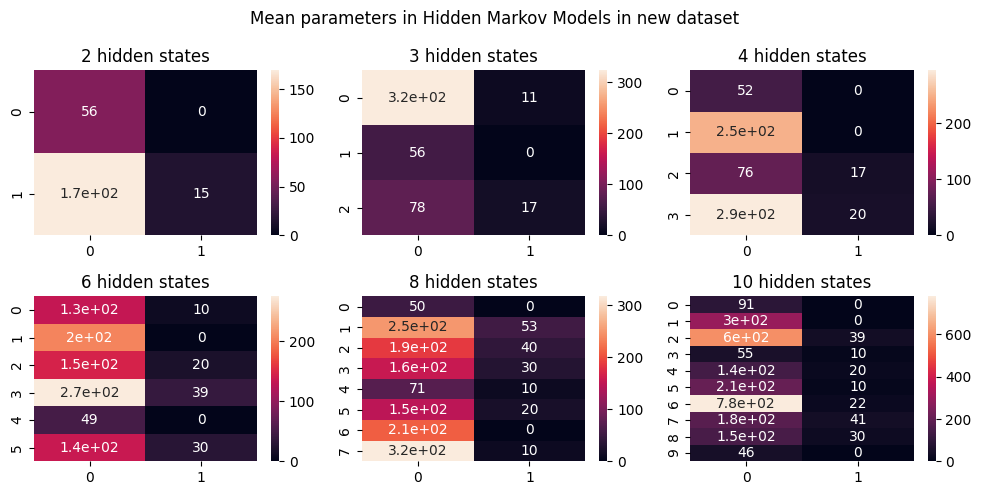

In [24]:
meanparams(v_both, 'new')

This plot also presents the same ambiguity of the heatmaps: consider the first plot of a certain hidden state as the `appliances` columns, and the second one as the `lights` column. The differences in value are also really at show here.

[]

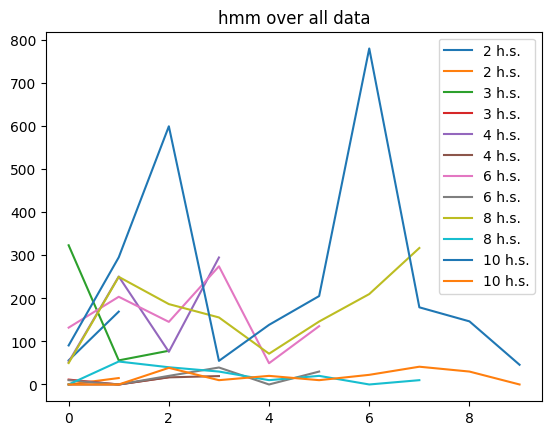

In [25]:
for i in hiddens:
  plt.title('hmm over all data') 
  plt.plot(v_both[i][4], label='{} h.s.'.format(i)) 
plt.legend()
plt.plot()

#### Transition matrices

In [26]:
%pip install hmmviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
from hmmviz import TransGraph

def plot_tm(seq):
  for i in hiddens:
    arr=seq[i][3]
    labels = seq[i][1]
    
    graph = TransGraph.from_array(arr, labels)

    colors ={0:'r', 1:'g', 2:'b', 3:'y', 4:'m', 5:'c', 6:'k', 7:'pink', 8:'gray', 9:'orange'}
    
    plt.figure(figsize=(6, 6))

    graph.draw(edgecolors=colors, nodecolors=colors, nodelabels=True, edgewidths=1)

  plt.show()

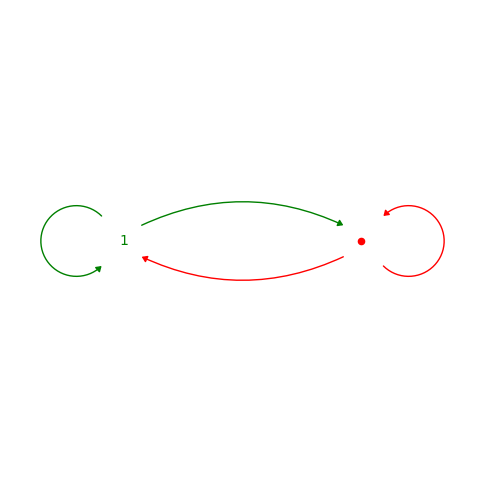

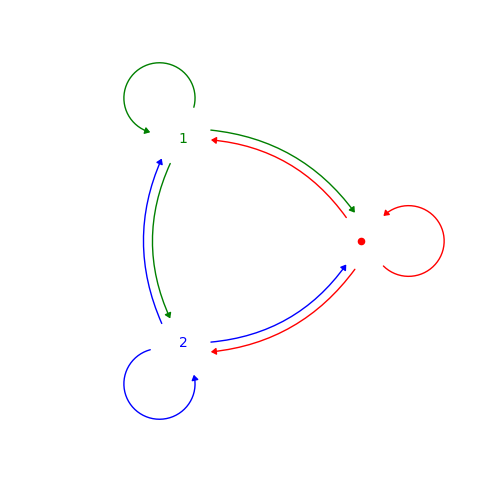

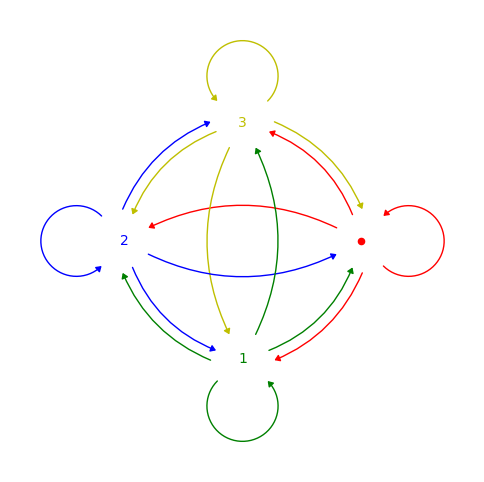

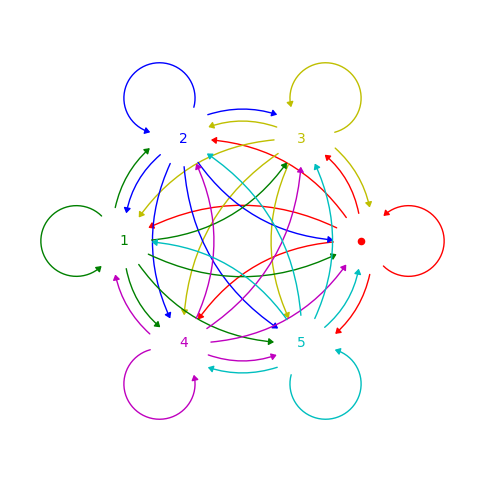

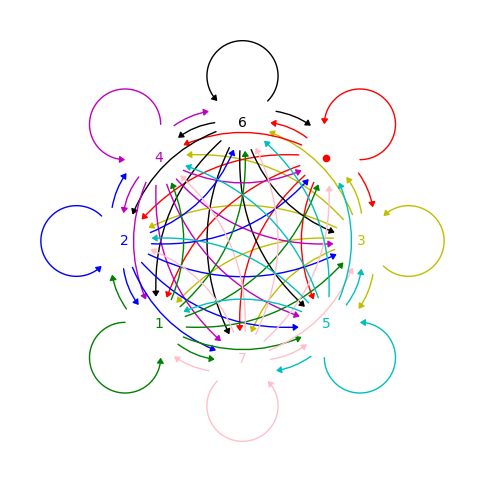

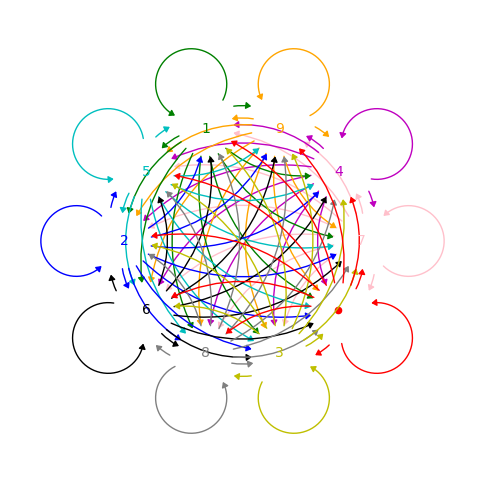

In [28]:
plot_tm(v_appl)

The **error** in the following plot is kept in the notebook as evidence of a peculiarity of the hidden states of the `lights` dataframe: it doesn't present all states in the numerical range from 0 to the number of states minus 1 like happens in the `appliances` dataframe.
This is probably caused by a missing edge that links the missing state to all the others, excluding it from the list of states and therefore creating a gap between the index of the transation matrix, which still follows the number of hidden states dictated by the `hiddens` list, and the shape of the states' array. 
This peculiarity only emerges from the models fitted with **8** and **10** hidden states.

ValueError: ignored

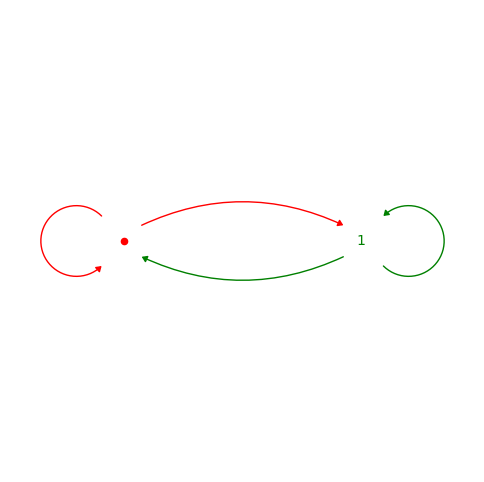

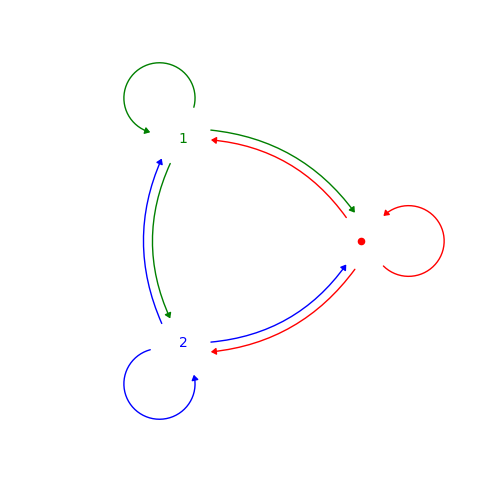

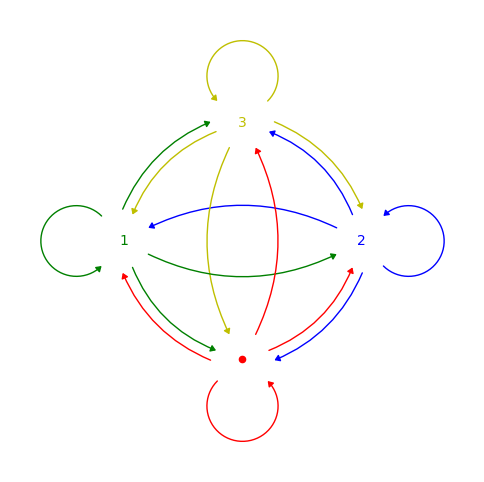

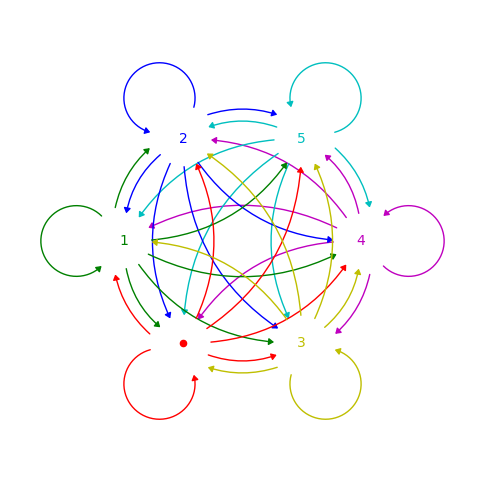

In [29]:
plot_tm(v_lights)

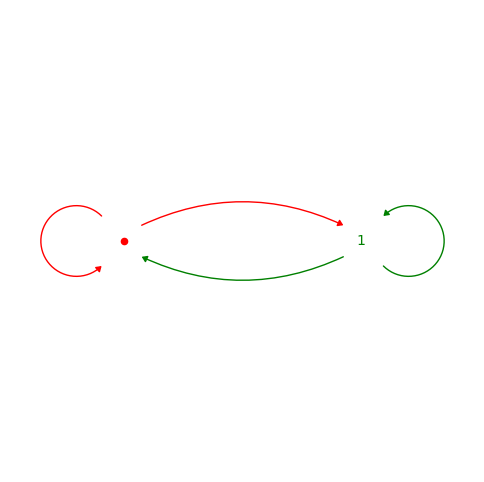

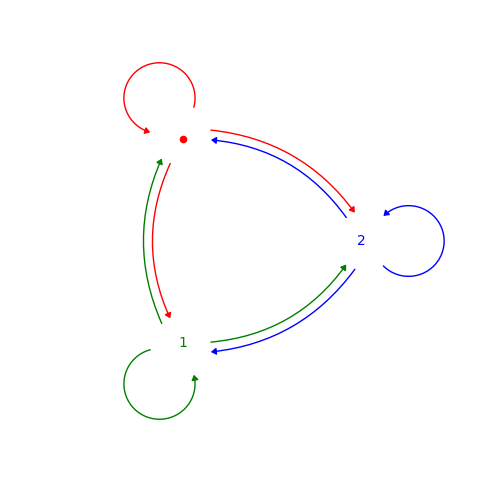

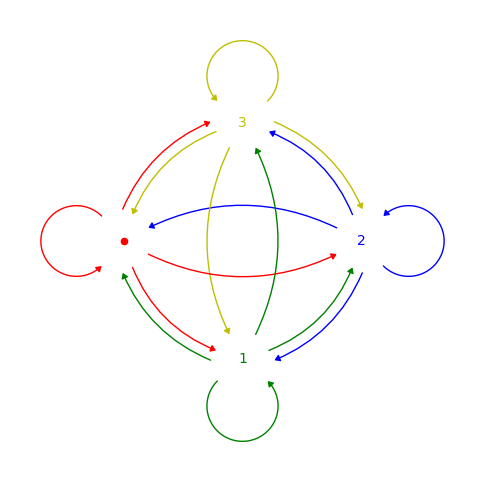

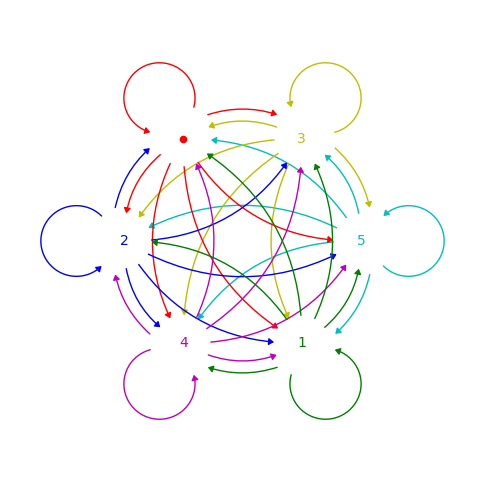

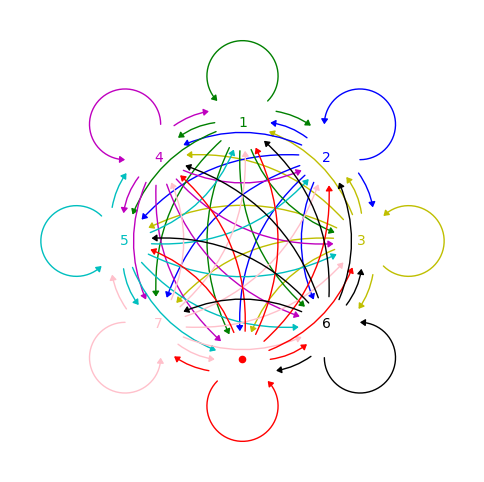

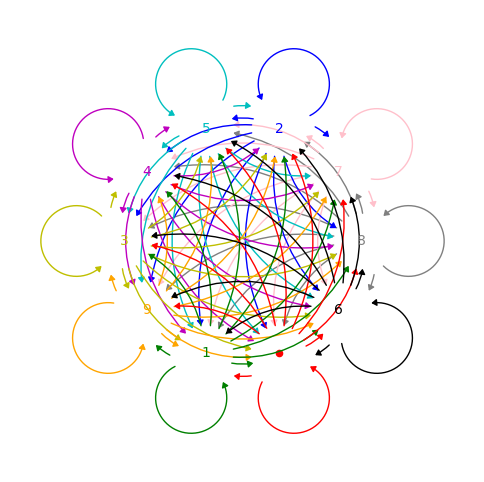

In [31]:
plot_tm(v_both)

## Some final considerations

- **About the time points**

It is very noticeable how in the `lights` dataframe the time points belonging to the same hidden state tend to concentrate on the same values, almost creating linear clusters (boldly saying). The time point-state correspondence is mostly evident in the `lights` dataframe that was fit in a HMM without the `appliances` dataset, while in the `lights` column fit together with the `appliance` column is evident some more intermingle between the hidden states. 

In the individually fit `appliances` dataframe also is visible some sort of stratification among the time points, while the `appliances` column of the latter fit of the `both` dataframe shows much more correlation between time points in hidden states.

It is to be noted that a higher number of hidden states generally favours a mingling on the values of the time points belonging to different hidden states. This is probably linked to the distribution of the mean parameters as well, and accordingly to the fact that we're working with gaussian emissions.



- **About the likelihood values**

As can be deduced from the summary of likelihood values printed below, in the singularly fit dataframes of `lights` and `appliances` the likelihood seems to grow at the same pace of the number of the hidden states, stating an increase in complexity also clearly visible in the transition matrices plots that is however accompanied by a better estimation and performance.

For what concerns the dataframe containing `lights` and `appliances` as its columns, keeping in mind how the negative log likelihood works, it seems that the lower numbers of hidden states worked better than the higher ones, especially 3 and 4 hidden states, that are the best results over all the predictions, giving us winners speaking in terms of likelihood measure only.


In [30]:
print('Likelihood of lights dataset:')
for i in hiddens:
  print('\t with {} hidden states = {}'.format(i, v_lights[i][2]))
print('Likelihood of appliances dataset:')
for i in hiddens:
  print('\t with {} hidden states = {}'.format(i, v_appl[i][2]))
print('Likelihood of dataset containing both lights and appliances:')
for i in hiddens:
  print('\t with {} hidden states = {}'.format(i, v_both[i][2]))

Likelihood of lights dataset:
	 with 2 hidden states = 21073.92155833288
	 with 3 hidden states = 31410.78636129573
	 with 4 hidden states = 38577.67838470473
	 with 6 hidden states = 39338.2015192197
	 with 8 hidden states = 41833.88547684005
	 with 10 hidden states = 41379.67008321382
Likelihood of appliances dataset:
	 with 2 hidden states = -43486.56198409604
	 with 3 hidden states = -43482.42283414887
	 with 4 hidden states = -39978.09163391503
	 with 6 hidden states = -39765.22113354041
	 with 8 hidden states = -39636.87094195282
	 with 10 hidden states = -38816.62343892656
Likelihood of dataset containing both lights and appliances:
	 with 2 hidden states = -30121.65499141613
	 with 3 hidden states = -27483.527467936095
	 with 4 hidden states = -23249.99941235493
	 with 6 hidden states = -5389.491849099073
	 with 8 hidden states = -4082.3704270389135
	 with 10 hidden states = -3964.018792865487
